In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import datetime
import os
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pickle
import seaborn as sns
from umap import UMAP


N_COMPONENTS = 10
rnd_seed = 42
path_repo = os.path.dirname(os.path.dirname(os.getcwd()))
path_plot = path_repo + '/figures'
path_pkl = path_repo + '/pkl'


In [8]:
def train_lgbm(model, param_grid, cv, X_train, y_train, label):
    gscv_target = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
    )

    gscv_target.fit(X_train, y_train)
    print('Best score:', gscv_target.best_score_)

    lgbm_target = gscv_target.best_estimator_
    print(lgbm_target.get_params())

    with open(path_pkl+'/'+label+'_gscv_target.pkl', 'wb') as f:
        pickle.dump(gscv_target, f)
        
    return gscv_target, lgbm_target

def plot_feature_importance(feature_names, global_importance, fig_title, path_plot=path_plot, filename_add=''):
    fig, ax = plt.subplots(figsize=(len(feature_names)/4, len(feature_names)/2))
    imp_index = np.argsort(global_importance)
    height = 0.3
    y_g = np.arange(len(imp_index))[::-1]
    ax.barh(y=y_g, width=global_importance[imp_index], height=height,
            color=sns.color_palette('bright')[0])
    ax.set_xlabel('Feature importance')
    ax.set_ylabel('Features')
    ax.set_yticks(np.arange(len(imp_index))[::-1])
    ax.set_yticklabels(feature_names[imp_index])
    sns.despine(fig=fig)
    ax.set_title(fig_title)
    fig.savefig(path_plot+'/feature_importance_'+filename_add+'.pdf', bbox_inches='tight')
    plt.show()
    return fig, ax

def plot_scatterplot_r2(y_test, predictions, fig_title, path_plot=path_plot, n_max=10000, filename_add=''):
    fig, ax = plt.subplots()
    sns.regplot(x=predictions[:n_max].astype(float), y=y_test[:n_max].astype(float), ax=ax, scatter_kws={"s": 1})
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    sns.despine(fig=fig)
    ax.set_title(fig_title)
    fig.savefig(path_plot+'/scatter_'+filename_add+'.pdf', bbox_inches='tight')
    plt.show()
    return fig, ax

In [9]:
def get_tid_pop(dct_pop, tid, day_index=15):
    ary_pop = dct_pop[tid]
    if len(ary_pop) > day_index:
        out = ary_pop[day_index]
        if out is not None:
            return out
    return np.nan

In [15]:
###DO THE MERGE ONCE WITH uk and fr databases
### 1
# df_merge = pd.read_csv('./table_lyrics_with_eval-Copy1.csv')
# df_merge = df_merge.drop(
#     columns=[
#         #'start_date', 'release_date', 'artist_id', 'artist_name',
#         #'album_id', 'album_name',
#         'ytv_ref', 'ytc_id', 'yt_pop_d15'
#     ],
#     errors='ignore'
# )
# df_merge.to_csv('./table_lyrics_with_eval.csv')#, index_label=False)
# df_merge

###2

# df_filtered = pd.read_csv('./embeddings/csv/filtered_with_feats-Copy1.csv', index_col=0)
# df_filtered = df_filtered.drop(
#     columns=['ytv_ref', 'ytc_id', 'yt_pop_d15'],
#     errors='ignore'
# )
# df_filtered.to_csv('./embeddings/csv/filtered_with_feats.csv')#, index_label=False)
# df_filtered

###3

# emb_folders = os.listdir('./embeddings/final_embeddings')
# #dct_umap = {}
# for emb in emb_folders:
#     if emb == '.DS_Store':
#         continue
#     df1 = pd.read_csv('./embeddings/final_embeddings/'+emb+'/data_train.csv', index_col=0)
#     df2 = pd.read_csv('./embeddings/final_embeddings/'+emb+'/data_eval.csv', index_col=0)
#     df3 = pd.read_csv('./embeddings/final_embeddings/'+emb+'/data_test.csv', index_col=0)
#     df4 = pd.read_csv('./embeddings/final_embeddings/'+emb+'/data.csv', index_col=0)
#     # df_emb = pd.concat([df1.loc[:,['track_id'] + list(df1.columns[40:])],
#     #                     df2.loc[:,['track_id'] + list(df2.columns[40:])],
#     #                     df3.loc[:,['track_id'] + list(df3.columns[40:])]],
#     #                    axis=0).reset_index(drop=True)
#     df1 = df1.drop(
#         columns=['ytv_ref', 'ytc_id', 'yt_pop_d15'],
#         errors='ignore'
#     )
#     df1.to_csv('./embeddings/final_embeddings/'+emb+'/data_train.csv')#, index_label=False)
    
#     df2 = df2.drop(
#         columns=['ytv_ref', 'ytc_id', 'yt_pop_d15'],
#         errors='ignore'
#     )
#     df2.to_csv('./embeddings/final_embeddings/'+emb+'/data_eval.csv')
    
#     df3 = df3.drop(
#         columns=['ytv_ref', 'ytc_id', 'yt_pop_d15'],
#         errors='ignore'
#     )
#     df3.to_csv('./embeddings/final_embeddings/'+emb+'/data_test.csv')

#     df4 = df4.drop(
#         columns=['ytv_ref', 'ytc_id', 'yt_pop_d15'],
#         errors='ignore'
#     )
#     df4.to_csv('./embeddings/final_embeddings/'+emb+'/data.csv')

###4

# df_fr = pd.read_csv('./res_dct_fr-Copy1.csv')

# df_fr = df_fr.drop(
#     columns=['days_from_fetch', 'dzDuration', 'dzTrackPos',
#              'dzBpm', 'dzGain', 'dzRank_day0', 'dzAlbumTracksN',
#              'dz_albumFans', 'delta_rel_deezer', 'delta_rel_youtube',
#              'ytv_ref', 'ytc_id', 'ytView_day0', 'ytLike_day0',
#              'ytDislike_day0', 'ytCommentN_day0', 'ytcSubscribers_day0',
#              'ytcVideo_day0', 'ytResp_day0', 'ytLknes_day0'],
#     errors='ignore'
# )
# df_fr.to_csv('./res_dct_fr.csv')#, index_label=False)

# df_uk = pd.read_csv('./res_dct_uk-Copy1.csv')
# df_uk = df_uk.drop(
#     columns=['days_from_fetch', 'dzDuration', 'dzTrackPos',
#              'dzBpm', 'dzGain', 'dzRank_day0', 'dzAlbumTracksN',
#              'dz_albumFans', 'delta_rel_deezer', 'delta_rel_youtube',
#              'ytv_ref', 'ytc_id', 'ytView_day0', 'ytLike_day0',
#              'ytDislike_day0', 'ytCommentN_day0', 'ytcSubscribers_day0',
#              'ytcVideo_day0', 'ytResp_day0', 'ytLknes_day0'],
#     errors='ignore'
# )
# df_uk.to_csv('./res_dct_uk.csv')#, index_label=False)

###5
# df_fr = pd.read_csv('./res_dct_fr.csv', index_col=0)
# df_uk = pd.read_csv('./res_dct_uk.csv', index_col=0)
# df_merge = pd.read_csv('./table_lyrics_with_eval.csv', index_col=0)

# with open('./dct_pop_sp_fr-Copy1.pkl', 'rb') as f:
#     dct_pop_spotify_fr = pickle.load(f)
# print(len(dct_pop_spotify_fr))

# with open('./dct_pop_sp_uk-Copy1.pkl', 'rb') as f:
#     dct_pop_spotify_uk = pickle.load(f)
# print(len(dct_pop_spotify_uk))

# new_dct_pop_spotify_fr = {}
# ok_tracks = df_fr[df_fr.track_id.isin(df_merge[df_merge.db_country=='fr'].track_id)].track_id.to_list()
# for tid, t_pop in dct_pop_spotify_fr.items():
#     if tid in ok_tracks:
#         new_dct_pop_spotify_fr[tid] = t_pop[:31]
# with open('./dct_pop_sp_fr.pkl', 'wb') as f:
#     pickle.dump(new_dct_pop_spotify_fr, f)


# new_dct_pop_spotify_uk = {}
# ok_tracks = df_uk[df_uk.track_id.isin(df_merge[df_merge.db_country=='uk'].track_id)].track_id.to_list()
# for tid, t_pop in dct_pop_spotify_uk.items():
#     if tid in ok_tracks:
#         new_dct_pop_spotify_uk[tid] = t_pop[:31]
# with open('./dct_pop_sp_uk.pkl', 'wb') as f:
#     pickle.dump(new_dct_pop_spotify_uk, f)


16852
10493


In [4]:
df_merge = pd.read_csv('./table_lyrics_with_eval.csv', index_col=0)

df_merge = df_merge.drop(
    columns=[
        'start_date', 'release_date', 'artist_id', 'artist_name',
        'album_id', 'album_name',
    ]
)


In [5]:
df_filtered = pd.read_csv('./embeddings/csv/filtered_with_feats.csv', index_col=0)
keep_cols = ['track_id'] + list(df_filtered.columns[14:])


df_merge = df_merge.join(
    df_filtered[keep_cols].set_index('track_id'),
    on='track_id'
)

,track_id,track_title,db_country,lyrics,train_eval_test,sp_pop_d15,lexical_token_count,lexical_unique_token_ratio,lexical_avg_token_length,lexical_repeated_token_ratio,...,lexical_digit_ratio,lexical_stop_words_ratio,lexical_avg_stop_words_per_line,linguistic_lemma_ratio,semantic_neg,semantic_neu,semantic_pos,semantic_compound,syntacric_pronoun_freq,syntacric_past_tense_ratio
0,003VDDA7J3Xb2ZFlNx7nIZ,YELL OH,fr,53 ContributorsYELL OH Lyrics[Chorus: Trippie ...,train,75.0,1191.0,0.164568,2.913518,0.835432,...,0.000000,0.302267,70.25,0.115029,0.249,0.582,0.169,-0.9990,0.122586,0.248408
1,00ETaeHUQ6lops3oWU1Wrt,Hot Stuff,fr,12 ContributorsHot Stuff Lyrics[Verse 1]\nSitt...,train,78.0,332.0,0.207831,3.466867,0.792169,...,0.000000,0.192771,50.00,0.147590,0.000,0.845,0.155,0.9893,0.039157,0.151515
2,00HxGKTPOh701Wv2gmbuA9,valentine's day,fr,12 ContributorsTranslationsEspañol​valentine’s...,train,58.0,501.0,0.245509,3.303393,0.754491,...,0.000000,0.419162,84.50,0.177645,0.165,0.672,0.163,-0.8537,0.159681,0.022727
3,00InqOBQrcdCu27lIYnoN2,Off Top (feat. 42 Dugg),fr,1 ContributorLatto [Discography List] LyricsMi...,train,54.0,10.0,1.000000,4.700000,0.000000,...,0.100000,0.000000,0.00,0.200000,0.000,1.000,0.000,0.0000,0.000000,0.000000
4,00SiZEELZ0K4gkUl0rU529,Bandsville,fr,24 ContributorsTranslationsPortuguêsBandsville...,train,68.0,334.0,0.395210,3.476048,0.604790,...,0.002994,0.275449,24.00,0.278443,0.154,0.691,0.155,-0.6519,0.113772,0.346154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24261,0RSFY15txSm6NUjTaTyyV8,Paranoia,uk,3 ContributorsПАРАНОЙЯ (PARANOIA) Lyrics[Текст...,test,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24262,21lP6bvtcbDcQMUrNVfVbK,Midnight Minus One,uk,NaN,test,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24263,2JvRRHzl9sQlSDTuvtvtuI,coming out (or something else like that),uk,NaN,test,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24264,5oVcHAljoK29s9k0eGjrG8,Terracotta Tiles,uk,1 ContributorTerracotta Tiles Lyrics[Verse 1]\...,test,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:

with open('./dct_pop_sp_fr.pkl', 'rb') as f:
    dct_pop_spotify_fr = pickle.load(f)
print(len(dct_pop_spotify_fr))

with open('./dct_pop_sp_uk.pkl', 'rb') as f:
    dct_pop_spotify_uk = pickle.load(f)
print(len(dct_pop_spotify_uk))

dct_pop = {'fr':dct_pop_spotify_fr, 'uk':dct_pop_spotify_uk}
# """
df_fr = pd.read_csv('./res_dct_fr.csv', index_col=0)
df_uk = pd.read_csv('./res_dct_uk.csv', index_col=0)



16571
7695


In [17]:
### PLOT POLUARITY IN 30 DAYS

time_interval = np.arange(31)
time_tid = []
for tt in time_interval:
    tid_pop_fr = [
        get_tid_pop(dct_pop_spotify_fr, k, day_index=tt)
        for k in df_fr[df_fr.track_id.isin(df_merge[df_merge.db_country=='fr'].track_id)].track_id
    ]
    tid_pop_uk = [
        get_tid_pop(dct_pop_spotify_uk, k, day_index=tt)
        for k in df_uk[df_uk.track_id.isin(df_merge[df_merge.db_country=='uk'].track_id)].track_id
    ]
    time_tid.append(tid_pop_fr+tid_pop_uk)
print(len(time_tid))

31


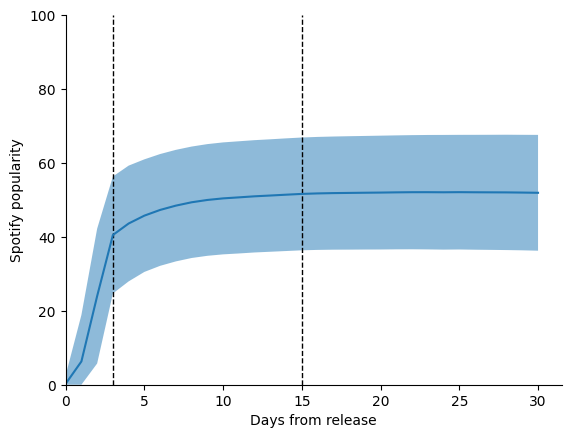

In [18]:
mean_pop = [np.nanmean(k) for k in time_tid]
up_pop = [np.minimum(100.,np.nanmean(k)+np.nanstd(k)) for k in time_tid]
down_pop = [np.maximum(0.,np.nanmean(k)-np.nanstd(k)) for k in time_tid]

fig, ax = plt.subplots()
ax.plot(time_interval,mean_pop)
ax.fill_between(x=time_interval, y1=up_pop, y2=down_pop, zorder=-1, alpha=0.5)
ax.axvline(15, zorder=-1, c='k', lw=1, ls='--')
ax.axvline(3, zorder=-1, c='k', lw=1, ls='--')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0, top=100)
ax.set_xlabel('Days from release')
ax.set_ylabel('Spotify popularity')
sns.despine(fig=fig)
fig.savefig(path_plot+'/average_spotify_popularity.pdf', bbox_inches='tight')

In [20]:
df_fr = df_fr[df_fr.track_id.isin(df_merge[df_merge.db_country=='fr'].track_id)]
track_pop_day1=[get_tid_pop(dct_pop_spotify_fr, k, day_index=1) for k in df_fr.track_id.values]
track_pop_day2=[get_tid_pop(dct_pop_spotify_fr, k, day_index=2) for k in df_fr.track_id.values]
track_pop_day3=[get_tid_pop(dct_pop_spotify_fr, k, day_index=3) for k in df_fr.track_id.values]
df_fr = df_fr.assign(
    track_pop_day1=track_pop_day1,
    track_pop_day2=track_pop_day2,
    track_pop_day3=track_pop_day3,
)

df_uk = df_uk[df_uk.track_id.isin(df_merge[df_merge.db_country=='uk'].track_id)]
track_pop_day1=[get_tid_pop(dct_pop_spotify_uk, k, day_index=1) for k in df_uk.track_id.values]
track_pop_day2=[get_tid_pop(dct_pop_spotify_uk, k, day_index=2) for k in df_uk.track_id.values]
track_pop_day3=[get_tid_pop(dct_pop_spotify_uk, k, day_index=3) for k in df_uk.track_id.values]
df_uk = df_uk.assign(
    track_pop_day1=track_pop_day1,
    track_pop_day2=track_pop_day2,
    track_pop_day3=track_pop_day3,
)

df_fruk = pd.concat([df_fr, df_uk], ignore_index=True)

df_merge = df_merge.join(
    df_fruk.set_index('track_id'),
    on='track_id'
)

In [25]:
sound_features = [
    'acousticness', 'danceability', 'duration_ms',
    'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness',
    'tempo', 'valence', 'album_type', 'explicit',
    'genre_class', 'music_style',
]

linguistic_features =[
    'lexical_token_count', 'lexical_unique_token_ratio',
    'lexical_avg_token_length', 'lexical_repeated_token_ratio',
    'lexical_hapax_dislegomenon', 'lexical_hapax_trislegomenon',
    'lexical_hapax_legomenon', 'lexical_avg_unique_tokens_per_line',
    'lexical_avg_tokens_per_line', 'lexical_line_count',
    'lexical_punctuation_ratio', 'lexical_digit_ratio',
    'lexical_stop_words_ratio', 'lexical_avg_stop_words_per_line',
    'linguistic_lemma_ratio', 'semantic_neg', 'semantic_neu',
    'semantic_pos', 'semantic_compound', 'syntacric_pronoun_freq',
    'syntacric_past_tense_ratio'
]
playlist_features = [
    'plmax_followers', 'plmax_pos', 'plmax_total', 'plsum_followers', 'play_num_day0',
]
spotify_features = [
    'nmark_day0', 'delta_rel_spotify', 'release_month', 'release_year', 'release_week', 'release_weekday',
]

post_release_sp_features = [
    'track_pop_day0', 'track_pop_day1', 'track_pop_day2','track_pop_day3'
]
artist_pop_features = ['art_pop_day0', 'art_fol_day0',]

In [24]:
###RUN THIS FOR THE FIRST EXPERIMENT
###FOR THE SECOND, COMMENT THIS AND RUN NEXT TWO CELL
emb_folders = os.listdir('./embeddings/final_embeddings')
for emb in emb_folders:
    if emb == '.DS_Store':
        continue
    df1 = pd.read_csv('./embeddings/final_embeddings/'+emb+'/data_train.csv', index_col=0)
    df2 = pd.read_csv('./embeddings/final_embeddings/'+emb+'/data_eval.csv', index_col=0)
    df3 = pd.read_csv('./embeddings/final_embeddings/'+emb+'/data_test.csv', index_col=0)
    df_emb = pd.concat([df1.loc[:,['track_id'] + list(df1.columns[37:])],
                        df2.loc[:,['track_id'] + list(df2.columns[37:])],
                        df3.loc[:,['track_id'] + list(df3.columns[37:])]],
                       axis=0).reset_index(drop=True)
    if 'dim_reduction' in emb:
        df_add = df_emb.rename(columns={'embedding_'+str(k):emb+'_'+str(k) for k in range(1,df_emb.shape[1])})
    else:
        train_emb = np.load('./embeddings/final_embeddings/'+emb+'/train.npy')
        eval_emb = np.load('./embeddings/final_embeddings/'+emb+'/eval.npy')
        umap_emb = np.vstack((train_emb, eval_emb))
        umap_l2 = UMAP(metric='euclidean', n_components=N_COMPONENTS, random_state=rnd_seed)
        umap_cos = UMAP(metric='cosine', n_components=N_COMPONENTS, random_state=rnd_seed)
        umap_l2_fit = umap_l2.fit(umap_emb)
        umap_cos_fit = umap_cos.fit(umap_emb)
        values_to_red = df_emb.iloc[:,1:].values
        red_l2 = umap_l2_fit.transform(values_to_red)
        red_cos = umap_cos_fit.transform(values_to_red)
        df_l2 = pd.DataFrame(red_l2, columns=[emb+'_l2_'+str(k) for k in range(1,red_l2.shape[1]+1)])
        df_cos = pd.DataFrame(red_cos, columns=[emb+'_cos_'+str(k) for k in range(1,red_cos.shape[1]+1)])
        
        df_add = pd.concat([df_emb.loc[:,['track_id']], df_l2, df_cos], axis=1)#, ignore_index=True)
    
    df_merge = df_merge.join(
        df_add.set_index('track_id'),
        on='track_id'
    )
    df_merge.to_csv('./dataset_first_exp.csv', index_label=False)

dct_emb = {}
for emb in emb_folders:
    if 'dim_reduction' in emb:
        dct_emb[emb] = [col for col in df_merge.columns if col.startswith(emb)]
    else:
        dct_emb[emb+'_l2'] = [col for col in df_merge.columns if col.startswith(emb+'_l2')]
        dct_emb[emb+'_cos'] = [col for col in df_merge.columns if col.startswith(emb+'_cos')]

/Users/giulio/Desktop/sony/FOREMUSIC/data_final/forenv/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/giulio/Desktop/sony/FOREMUSIC/data_final/forenv/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/giulio/Desktop/sony/FOREMUSIC/data_final/forenv/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/giulio/Desktop/sony/FOREMUSIC/data_final/forenv/lib/python3.9/s

In [ ]:
# ###RUN THIS FOR THE SECOND EXPERIMENT
# emb_folders = ['ft_st_all_mpnet_base_v2_ft_regression']
# #for N_COMPONENTS in [5, 10, 20]:
# for emb in emb_folders:
#     if emb == '.DS_Store':
#         continue
#     df1 = pd.read_csv('./embeddings/final_embeddings/'+emb+'/data_train.csv', index_col=0)
#     df2 = pd.read_csv('./embeddings/final_embeddings/'+emb+'/data_eval.csv', index_col=0)
#     df3 = pd.read_csv('./embeddings/final_embeddings/'+emb+'/data_test.csv', index_col=0)
#     df_emb = pd.concat([df1.loc[:,['track_id'] + list(df1.columns[40:])],
#                         df2.loc[:,['track_id'] + list(df2.columns[40:])],
#                         df3.loc[:,['track_id'] + list(df3.columns[40:])]],
#                        axis=0).reset_index(drop=True)
#     #keep_cols = ['track_id'] + list(df_emb.columns[40:])
#     #df_emb = df_emb.loc[:,keep_cols]
#     if 'dim_reduction' in emb:
#         df_add = df_emb.rename(columns={'embedding_'+str(k):emb+'_'+str(k) for k in range(1,df_emb.shape[1])})
#     else:
#         train_emb = np.load('./embeddings/final_embeddings/'+emb+'/train.npy')
#         eval_emb = np.load('./embeddings/final_embeddings/'+emb+'/eval.npy')
#         umap_emb = np.vstack((train_emb, eval_emb))
#         umap_l2 = UMAP(metric='euclidean', n_components=N_COMPONENTS, random_state=rnd_seed)
#         #umap_cos = UMAP(metric='cosine', n_components=N_COMPONENTS, random_state=rnd_seed)
#         umap_l2_fit = umap_l2.fit(umap_emb)
#         #umap_cos_fit = umap_cos.fit(umap_emb)
#         values_to_red = df_emb.iloc[:,1:].values
#         red_l2 = umap_l2_fit.transform(values_to_red)
#         #red_cos = umap_cos_fit.transform(values_to_red)
#         df_l2 = pd.DataFrame(red_l2, columns=[emb+'_umap'+str(k) for k in range(1,red_l2.shape[1]+1)])
#         #df_cos = pd.DataFrame(red_cos, columns=[emb+'_cos_'+str(k) for k in range(1,red_cos.shape[1]+1)])
        
#         #df_add = pd.concat([df_emb.loc[:,['track_id']], df_l2, df_cos], axis=1)#, ignore_index=True)
#         df_add = pd.concat([df_emb.loc[:,['track_id']], df_l2], axis=1)#, ignore_index=True)
    
#     df_merge = df_merge.join(
#         df_add.set_index('track_id'),
#         on='track_id'
#     )
#     

# embed_cols = [col for col in df_merge.columns if col.startswith(emb)]
# dct_rename = {col:'embedding_'+str(k+1) for k,col in enumerate(embed_cols)}
# df_merge = df_merge.rename(columns=dct_rename)
# embedding_features = list(dct_rename.values())
# df_merge.to_csv('./dataset_second_experiment.csv', index_label=False)

In [ ]:
###RUN THIS FOR THE SECOND EXPERIMENT

# dct_feats = {
#     'linguistic': linguistic_features,
#     'sound' : sound_features,
#     'sound+linguistic' : sound_features + linguistic_features,
#     # 'other_platform' : df[sound_features + playlist_features
#     #    + spotify_features + artist_pop_features
#     # ],
#     'platform' : sound_features #+ playlist_features
#         + spotify_features #+ youtube_features
#         + artist_pop_features
#     ,
#     'platform+linguistic' : sound_features + linguistic_features#+ playlist_features
#         + spotify_features #+ youtube_features
#         + artist_pop_features
#     ,
#     'playlist' : sound_features
#         + spotify_features #+ youtube_features
#         + artist_pop_features
#         + playlist_features
#     ,
#     'playlist+linguistic' : sound_features + linguistic_features
#         + spotify_features #+ youtube_features
#         + artist_pop_features
#         + playlist_features
#     ,
#     'reactions' : sound_features
#         + spotify_features #+ youtube_features
#         + artist_pop_features
#         + playlist_features
#         + post_release_sp_features
#     ,
#     'reactions+linguistic' : sound_features + linguistic_features
#         + spotify_features #+ youtube_features
#         + artist_pop_features
#         + playlist_features
#         + post_release_sp_features
#     ,
#     'embeddings':embedding_features,
#     'linguistic+embeddings': linguistic_features + embedding_features,
#     'sound+embeddings' : sound_features + embedding_features,
#     'sound+linguistic+embeddings' : sound_features + linguistic_features + embedding_features,
#     # 'other_platform' : df[sound_features + playlist_features
#     #    + spotify_features + artist_pop_features
#     # ],
#     'platform+embeddings' : sound_features + embedding_features #+ playlist_features
#         + spotify_features #+ youtube_features
#         + artist_pop_features
#     ,
#     'platform+linguistic+embeddings' : sound_features + linguistic_features + embedding_features#+ playlist_features
#         + spotify_features #+ youtube_features
#         + artist_pop_features
#     ,
#     'playlist+embeddings' : sound_features + embedding_features
#         + spotify_features #+ youtube_features
#         + artist_pop_features
#         + playlist_features
#     ,
#     'playlist+linguistic+embeddings' : sound_features + linguistic_features + embedding_features
#         + spotify_features #+ youtube_features
#         + artist_pop_features
#         + playlist_features
#     ,
#     'reactions+embeddings' : sound_features + embedding_features
#         + spotify_features #+ youtube_features
#         + artist_pop_features
#         + playlist_features
#         + post_release_sp_features
#     ,
#     'reactions+linguistic+embeddings' : sound_features + linguistic_features + embedding_features
#         + spotify_features #+ youtube_features
#         + artist_pop_features
#         + playlist_features
#         + post_release_sp_features
#     ,
# } 

In [30]:

param_grid = {
    'learning_rate':[0.001],#, 0.01],
    'n_estimators':[10000],#[1000, 10000],#, 17500, 20000],
    'max_depth':[6, -1],
    'num_leaves':[40, 60],#, 65, 70],#, 128, 256, 512],
    'colsample_bytree':[0.7, 1],
}

param_grid_debug = {
    'learning_rate':[0.1],
    'n_estimators':[10],#, 17500, 20000],
    'max_depth':[5],
    'num_leaves':[30],#, 65, 70],#, 128, 256, 512],
    'colsample_bytree':[0.7],
}

cv = 5

model = LGBMRegressor(objective='regression_l2', n_jobs=-1,
                      #random_state=rnd_seed,
                      force_col_wise=True,
                      verbosity=-1,
                     )

linguistic-sp_pop_d15
Best score: -0.05332511821489376
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.7, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 10, 'n_jobs': -1, 'num_leaves': 30, 'objective': 'regression_l2', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'force_col_wise': True, 'verbosity': -1}
MAE= 11.814 RMSE= 14.629 R2= 0.14


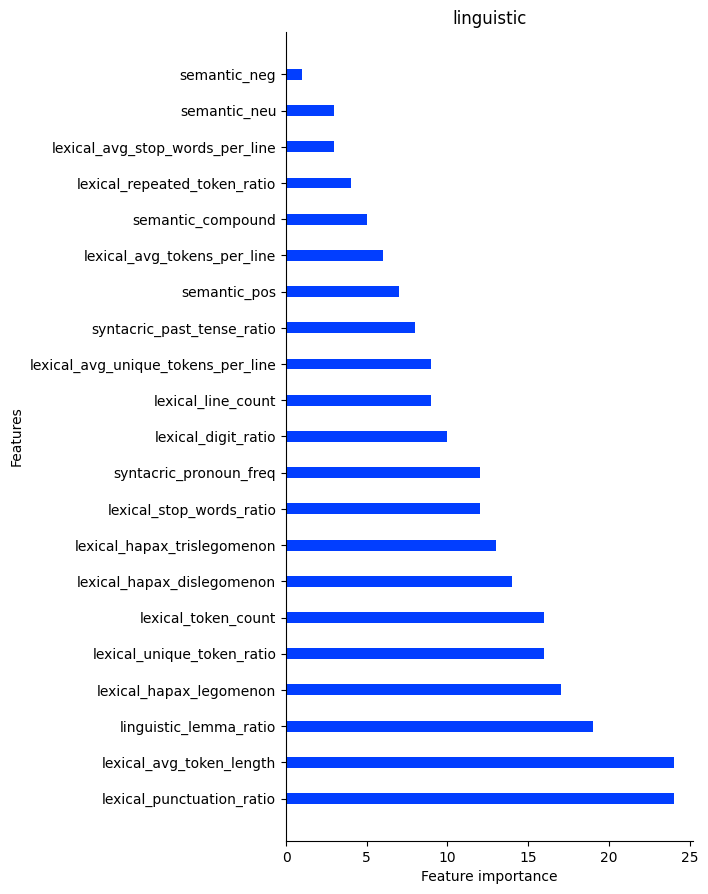

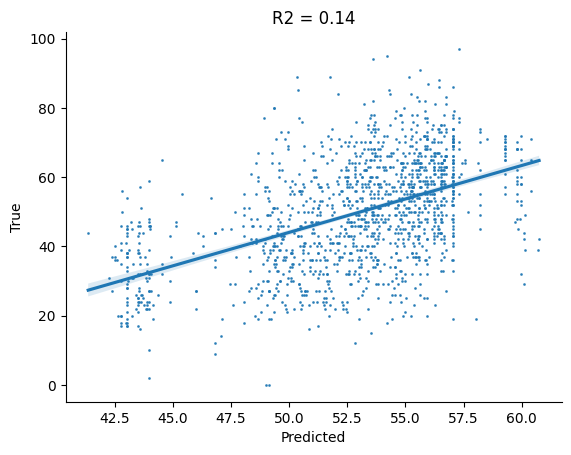

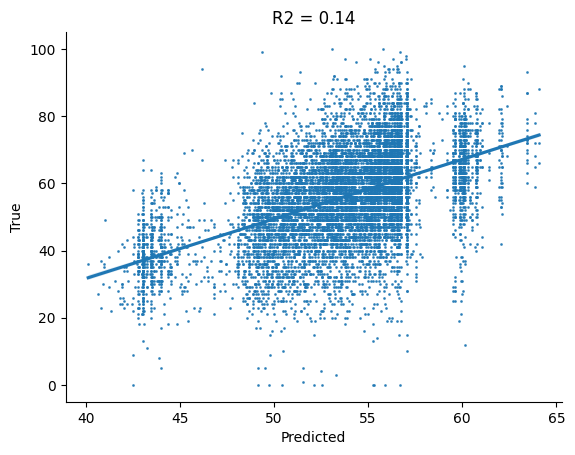

st_all_mpnet_base_v2_ft_regression_l2-sp_pop_d15
Best score: 0.021147204738876258
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.7, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 10, 'n_jobs': -1, 'num_leaves': 30, 'objective': 'regression_l2', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'force_col_wise': True, 'verbosity': -1}
MAE= 10.954 RMSE= 13.734 R2= 0.196


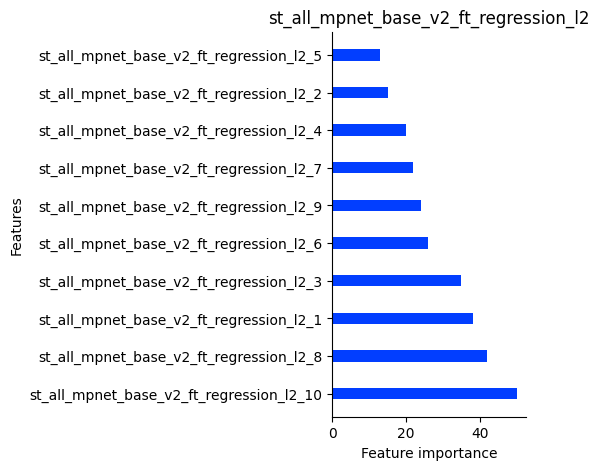

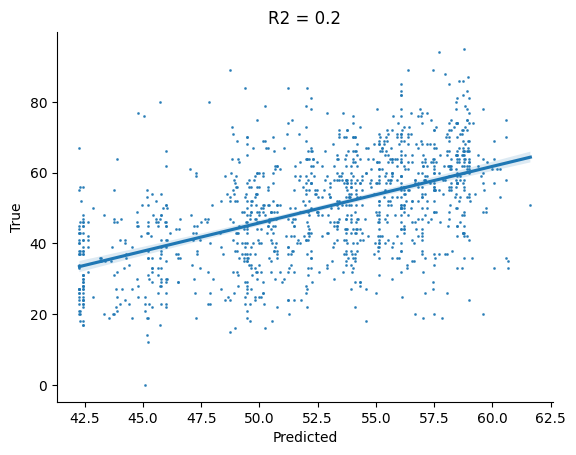

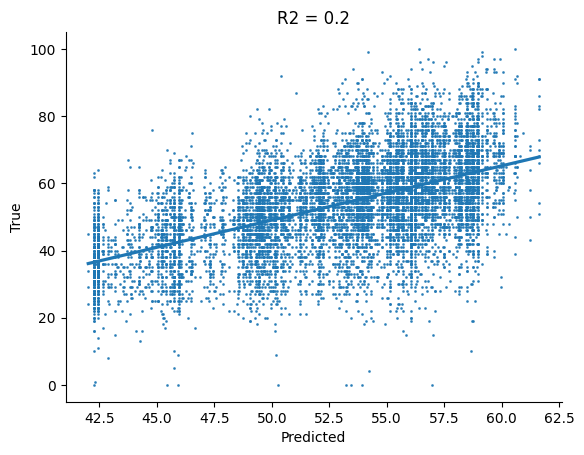

st_all_mpnet_base_v2_ft_regression_cos-sp_pop_d15
Best score: 0.02038924375778086
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.7, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 10, 'n_jobs': -1, 'num_leaves': 30, 'objective': 'regression_l2', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'force_col_wise': True, 'verbosity': -1}
MAE= 10.963 RMSE= 13.742 R2= 0.195


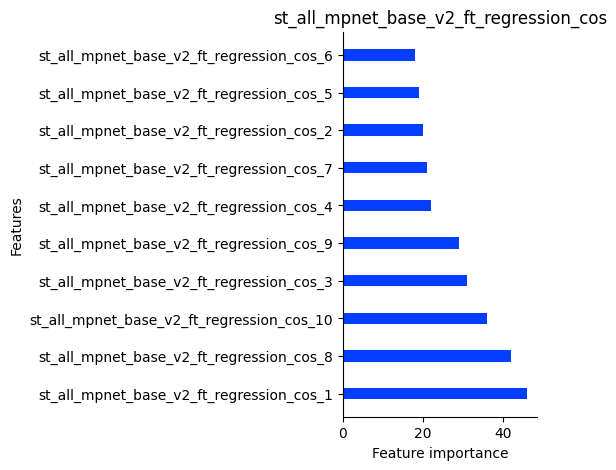

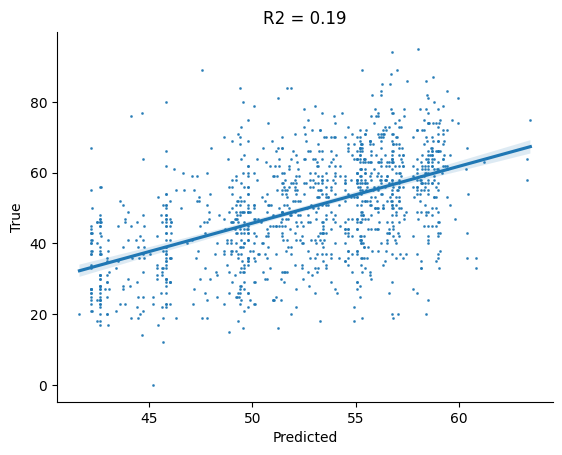

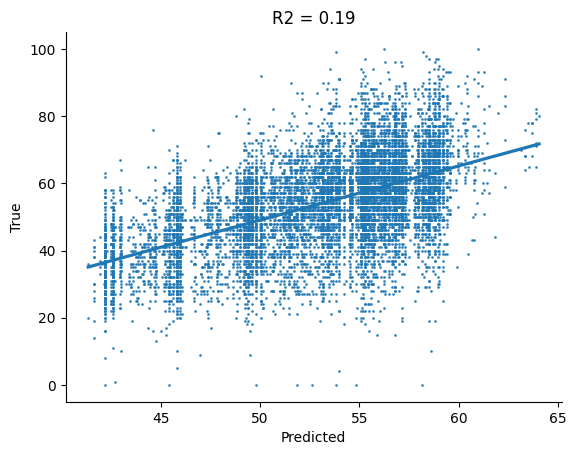

st_all_mpnet_base_v2_dim_reduction_5_ft_regression-sp_pop_d15
Best score: -0.04165670396316008
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.7, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 10, 'n_jobs': -1, 'num_leaves': 30, 'objective': 'regression_l2', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'force_col_wise': True, 'verbosity': -1}
MAE= 11.258 RMSE= 14.013 R2= 0.163


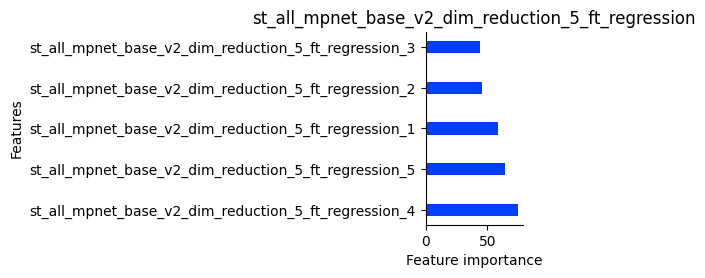

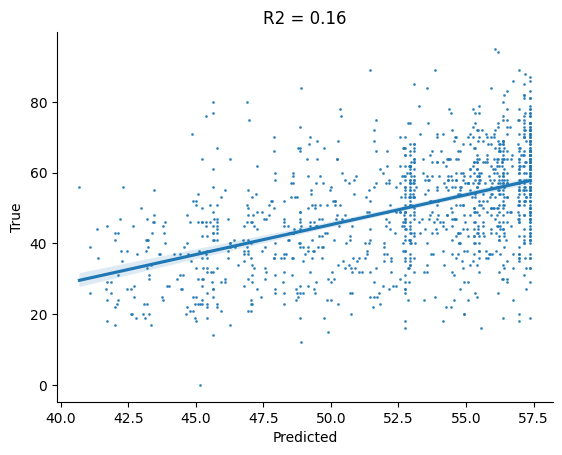

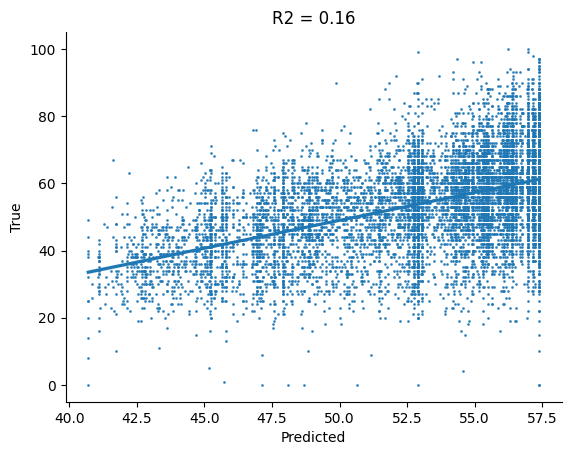

ft_st_all_mpnet_base_v2_dim_reduction_5_ft_regression-sp_pop_d15
Best score: -0.07618263399913949
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.7, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 10, 'n_jobs': -1, 'num_leaves': 30, 'objective': 'regression_l2', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'force_col_wise': True, 'verbosity': -1}
MAE= 11.414 RMSE= 14.154 R2= 0.146


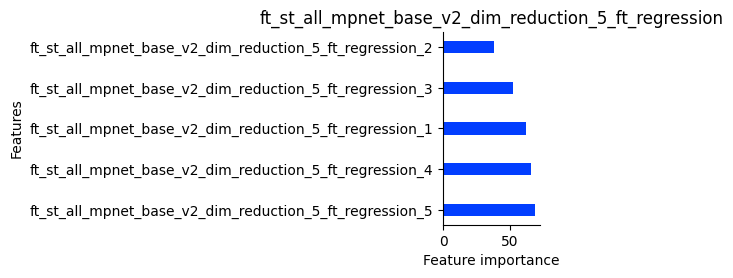

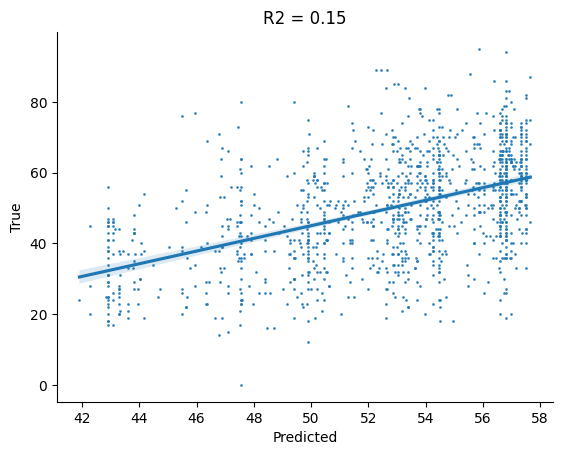

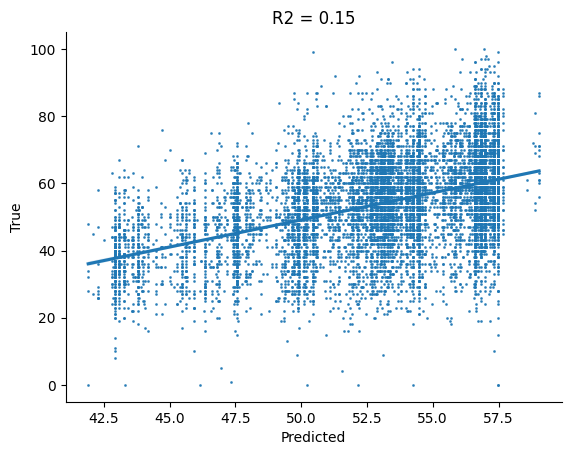

st_all_mpnet_base_v2_dim_reduction_20_ft_regression-sp_pop_d15
Best score: 0.05397654407600192
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.7, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 10, 'n_jobs': -1, 'num_leaves': 30, 'objective': 'regression_l2', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'force_col_wise': True, 'verbosity': -1}
MAE= 11.03 RMSE= 13.766 R2= 0.192


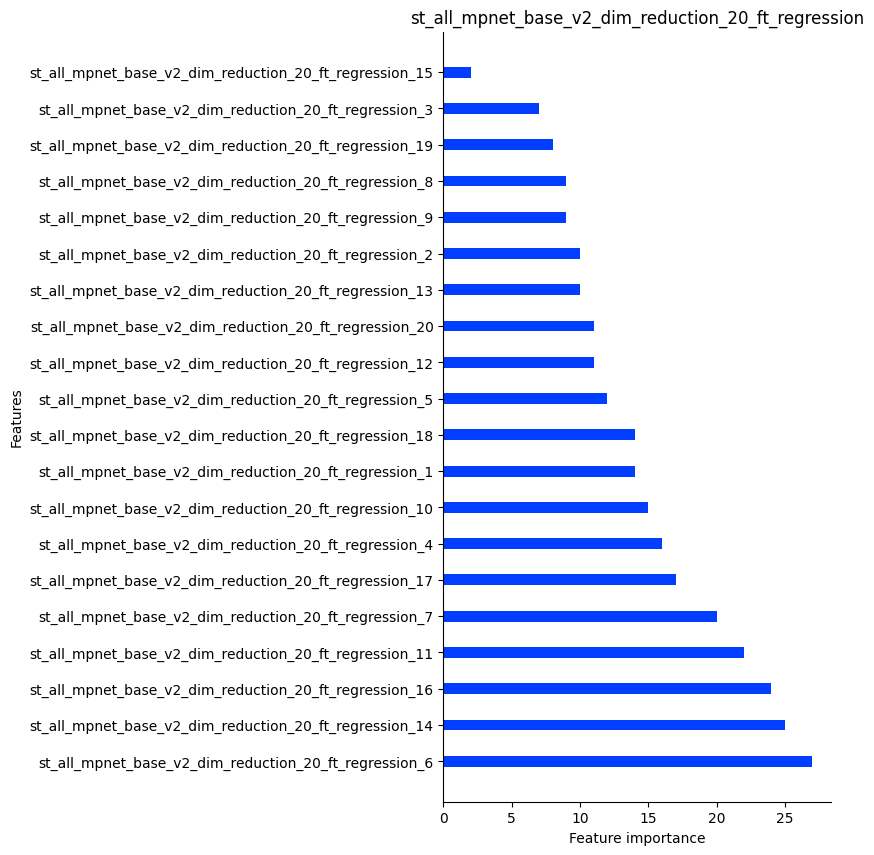

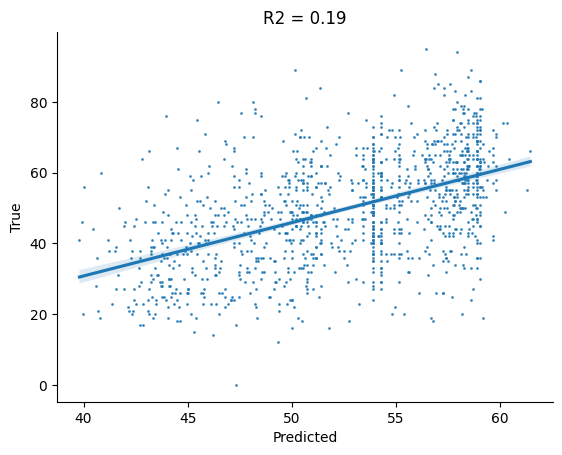

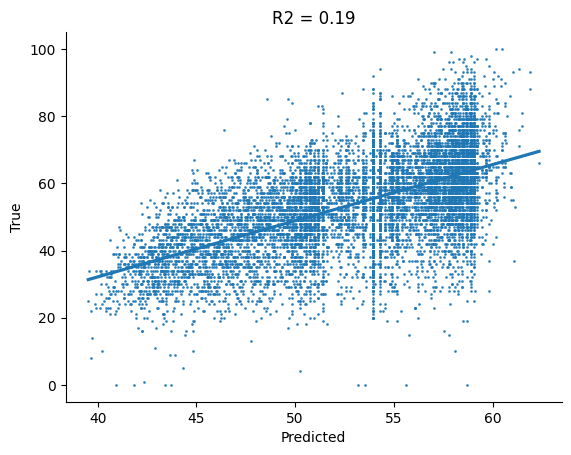

ft_st_all_mpnet_base_v2_dim_reduction_20_ft_regression-sp_pop_d15
Best score: -0.2288044707297348
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.7, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 10, 'n_jobs': -1, 'num_leaves': 30, 'objective': 'regression_l2', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'force_col_wise': True, 'verbosity': -1}
MAE= 12.421 RMSE= 15.29 R2= 0.003


KeyboardInterrupt: 

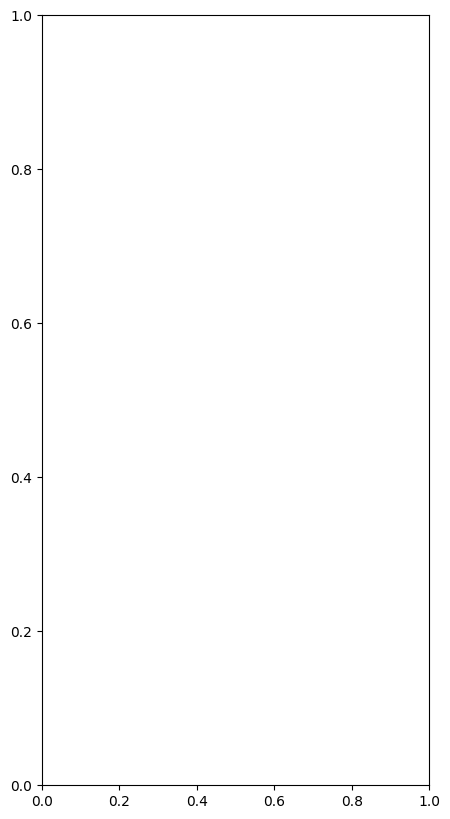

In [36]:
target = 'sp_pop_d15' 
training_res = {}
###TO RUN SECOND EXPERIMENT, REPLACE THE for CYCLE WITH THE LINE BELOW
#for X_label in dct_feats.keys():

###RUN FIRST EXPERIMENT WITH UMAP DIM = N_COMPONENTS
for X_label in ['linguistic']+list(dct_emb.keys()):

    y = df_merge[target]
    X = df_merge[dct_feats[X_label]]
    good_X_index = X.dropna().index
    good_y_index = y[y.notna()].index
    notna_index = good_X_index.intersection(good_y_index)
    X = X.loc[notna_index]
    y = y.loc[notna_index]
    is_train = df_merge.loc[notna_index].train_eval_test.isin(['train', 'eval'])
    is_test = ~is_train
    
    X_train = X[is_train]
    X_test = X[is_test]

    y_train = y[is_train]
    y_test = y[is_test]

    
    label = X_label+'-'+target
    print(label)
    #gscv_target, lgbm_target = train_lgbm(model, param_grid, cv, X_train, y_train, label)
    gscv_target, lgbm_target = train_lgbm(model, param_grid_debug, cv, X_train, y_train, label)

    lgbm_target = gscv_target.best_estimator_
    predictions_train = lgbm_target.predict(X_train)
    predictions = lgbm_target.predict(X_test)

    mae_score_train = mean_absolute_error(y_train, predictions_train)
    mae_score = mean_absolute_error(y_test, predictions)
    
    r2score_train = r2_score(y_train, predictions_train)
    r2score = r2_score(y_test, predictions)
    
    mse_score_train = mean_squared_error(y_train, predictions_train)
    mse_score = mean_squared_error(y_test, predictions)
    
    print('MAE=', round(mae_score, 3),
          'RMSE=', round(np.sqrt(mse_score), 3),
          'R2=', round(r2score, 3),
         )
    lab = 'R2 = {}'.format(round(r2score, 2))   
    global_importance = lgbm_target.feature_importances_
    feature_names = np.array(lgbm_target.feature_name_)

    training_res[X_label] = [
        round(sc, 2) for sc in [mae_score_train,
                                np.sqrt(mse_score_train),
                                r2score_train]
    ]
    
    plot_feature_importance(feature_names, global_importance, X_label, filename_add=label)
    plot_scatterplot_r2(y_test, predictions, fig_title=lab, filename_add=label)
    plot_scatterplot_r2(y_train, lgbm_target.predict(X_train), fig_title=lab, filename_add=label+' train')

    

In [37]:
# for k,v in training_res.items():
#     if k.startswith('st_'):
#         print(k)
#         print(training_res[k])
#         print(training_res['ft_'+k])